# Simulasi Penataan Kontainer Kapal

Notebook ini mensimulasikan penataan kontainer berdasarkan kategori berat (berat/sedang/ringan) dan tujuan pelabuhan (Makassar, Ambon, Jayapura), dengan aturan:

- Kontainer berat ditempatkan di bawah, sedang di tengah, ringan di atas.
- Aksesibilitas bongkar: kontainer untuk pelabuhan awal harus lebih mudah diakses (lebih atas) dibanding pelabuhan akhir.
- Kapasitas contoh: 450 kontainer, dibagi ke 9 bay, masing-masing 50 slot (10 stack × 5 tier).

Visualisasi menggunakan color coding:
- Hijau: ringan
- Kuning: sedang
- Merah: berat

Silakan jalankan sel-sel di bawah berurutan.


In [335]:
# Setup: impor dan utilitas
import math
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)

# Konstanta kategori berat
WEIGHT_CATEGORIES = ["light", "medium", "heavy"]
WEIGHT_TO_COLOR = {"light": "#2ecc71", "medium": "#f1c40f", "heavy": "#e74c3c"}
WEIGHT_PRIORITY = {"heavy": 0, "medium": 1, "light": 2}  # untuk stacking bottom-up

# Struktur kontainer
@dataclass
class Container:
    id: int
    dest: str
    weight_cat: str
    weight_ton: float  # berat numerik aktual

# Struktur posisi: bay, stack (kolom), tier (baris/tinggi)
@dataclass
class Position:
    bay: int
    stack: int
    tier: int



In [336]:
# Parameter simulasi (dapat diubah)
TOTAL_CONTAINERS = 450
BAYS = 9
STACKS_PER_BAY = 10   # kolom per bay
TIERS_PER_STACK = 5   # tinggi per stack
assert BAYS * STACKS_PER_BAY * TIERS_PER_STACK == 450
MAKASSAR_CONTAINER = 190
AMBON_CONTAINER = 142
JAYAPURA_CONTAINER = 89

# Urutan pelabuhan pada rute (awal -> akhir)
PORTS = ["Makassar", "Ambon", "Jayapura"]

# Alokasi jumlah kontainer per tujuan
ALLOCATION_PER_PORT = {
    "Makassar": MAKASSAR_CONTAINER,
    "Ambon": AMBON_CONTAINER,
    "Jayapura": JAYAPURA_CONTAINER,
}

# Proporsi kategori berat per tujuan (akan dinormalisasi jika tidak pas 1.0)
WEIGHT_MIX = {
    "Makassar": {"light": 0.6, "medium": 0.3, "heavy": 0.1},
    "Ambon":    {"light": 0.3, "medium": 0.5, "heavy": 0.2},
    "Jayapura": {"light": 0.25, "medium": 0.45, "heavy": 0.30},
}

# Rentang berat (ton) per kategori
WEIGHT_RANGES = {
    "light": (8.0, 12.9),
    "medium": (13.0, 19.9),
    "heavy": (20.0, 25.0),
}

# Konstanta singkatan tujuan dan kategori berat untuk anotasi
DEST_TO_ABBR = {
    "Makassar": "M",
    "Ambon": "A",
    "Jayapura": "J",
}
WEIGHT_ABBR = {"light": "L", "medium": "M", "heavy": "H"}

# Parameter hidrostatik sederhana untuk perhitungan GM
# CATATAN: Angka-angka ini placeholder dan harus diganti dengan data kapal sebenarnya.
# Satuan ton, meter.
LIGHTSHIP_DISP_T = 3000.0   # berat lightship (tanpa muatan)
LIGHTSHIP_KG_M = 6.5        # vertical CoG lightship di atas keel
LIGHTSHIP_LCG_M = 0.0       # longitudinal CoG lightship relatif titik nol bay tengah
LIGHTSHIP_TCG_M = 0.0       # transverse CoG lightship relatif centerline

KB_M = 3.0                  # jarak dari keel ke pusat daya apung (KB)
BM_TRANSVERSE_M = 4.0       # BMt (metacentric radius transversal)
BM_LONGITUDINAL_M = 50.0    # BMl (metacentric radius longitudinal)

# Geometri vertikal tier untuk menghitung KG muatan
TIER_HEIGHT_M = 2.6         # jarak antar tier (dek bawah ke atas)
TIER_BASE_Z_M = 1.3         # elevasi tier 0 dari keel (misal center of mass container)



In [337]:
def normalize_mix(mix: Dict[str, float]) -> Dict[str, float]:
    total = sum(mix.values())
    if total == 0:
        # fallback rata
        n = len(mix)
        return {k: 1.0 / n for k in mix}
    return {k: v / total for k, v in mix.items()}


def generate_containers(
    total: int,
    allocation_per_port: Dict[str, int],
    weight_mix: Dict[str, Dict[str, float]],
) -> List[Container]:
    containers: List[Container] = []
    container_id = 1
    for port, count in allocation_per_port.items():
        mix = normalize_mix(weight_mix.get(port, {c: 1/3 for c in WEIGHT_CATEGORIES}))
        # jumlah per kategori via multinomial
        probs = [mix.get("light", 0), mix.get("medium", 0), mix.get("heavy", 0)]
        cat_counts = np.random.multinomial(count, probs)
        cats = ["light", "medium", "heavy"]
        for cat, c in zip(cats, cat_counts):
            for _ in range(c):
                wmin, wmax = WEIGHT_RANGES[cat]
                w = float(np.random.uniform(wmin, wmax))
                containers.append(Container(id=container_id, dest=port, weight_cat=cat, weight_ton=w))
                container_id += 1
    # jika rounding tidak sempurna (multinomial harus pas, tapi berjaga-jaga)
    if len(containers) != total:
        # trimming atau padding ringan
        if len(containers) > total:
            containers = containers[:total]
        else:
            while len(containers) < total:
                wmin, wmax = WEIGHT_RANGES["light"]
                w = float(np.random.uniform(wmin, wmax))
                containers.append(Container(id=container_id, dest=PORTS[-1], weight_cat="light", weight_ton=w))
                container_id += 1
    return containers



In [338]:
def plan_stowage(containers, bays, stacks_per_bay, tiers_per_stack,
                 ports_order, port_to_bays=None, fa_lambda=1.0):
    if port_to_bays is None:
        port_to_bays = {p: list(range(bays)) for p in ports_order}

    # koordinat bay (nol di midship) untuk momen longitudinal
    bay_coords = np.linspace(-(bays-1)/2, (bays-1)/2, bays)

    by_port = {p: [] for p in ports_order}
    for c in containers:
        if c.dest in by_port:
            by_port[c.dest].append(c)

    assignment = {}
    bay_stack_weights = {bay: [0.0]*stacks_per_bay for bay in range(bays)}
    bay_stack_fill = {bay: [0]*stacks_per_bay for bay in range(bays)}
    bay_total_weight = {bay: 0.0 for bay in range(bays)}

    def current_longitudinal_moment():
        return sum(bay_total_weight[b] * bay_coords[b] for b in range(bays))

    for port in ports_order[::-1]:
        port_conts = sorted(by_port.get(port, []), key=lambda c: WEIGHT_PRIORITY[c.weight_cat])
        candidate_bays = port_to_bays.get(port, [])
        for cont in port_conts:
            best_score, best_bay = None, None
            M_now = current_longitudinal_moment()
            for b in candidate_bays:
                # ada slot di bay b?
                if not any(bay_stack_fill[b][s] < tiers_per_stack for s in range(stacks_per_bay)):
                    continue
                # simulasi momen setelah menaruh kontainer di bay b
                M_after = M_now + cont.weight_ton * bay_coords[b]
                score = bay_total_weight[b] + fa_lambda * abs(M_after)
                if best_score is None or score < best_score:
                    best_score, best_bay = score, b
            if best_bay is None:
                continue
            # pilih stack teringan di bay terpilih
            candidates = [(bay_stack_weights[best_bay][s], s)
                          for s in range(stacks_per_bay)
                          if bay_stack_fill[best_bay][s] < tiers_per_stack]
            if not candidates:
                continue
            _, target_stack = min(candidates)
            target_tier = bay_stack_fill[best_bay][target_stack]
            assignment[(best_bay, target_stack, target_tier)] = cont
            bay_stack_fill[best_bay][target_stack] += 1
            bay_stack_weights[best_bay][target_stack] += cont.weight_ton
            bay_total_weight[best_bay] += cont.weight_ton
    return assignment



In [339]:
def visualize_all_bays_detailed(assignment: Dict[Tuple[int,int,int], Container], bays: int,
                                 stacks_per_bay: int, tiers_per_stack: int):
    cols = 3
    rows = math.ceil(bays / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*4.5))
    axes = np.atleast_2d(axes)

    for bay in range(bays):
        r, c = divmod(bay, cols)
        ax = axes[r, c]
        total_bay_weight = 0.0
        # gambar cell sebagai kotak dengan grid
        for stack in range(stacks_per_bay):
            stack_weight = 0.0
            for tier in range(tiers_per_stack):
                cont = assignment.get((bay, stack, tier))
                if cont is None:
                    color_hex = "#eeeeee"
                else:
                    color_hex = WEIGHT_TO_COLOR[cont.weight_cat]
                # koordinat rect: x=stack, y=tiers_per_stack-1-tier agar 0 di bawah
                x = stack
                y = tiers_per_stack-1-tier
                rect = plt.Rectangle((x, y), 1, 1, facecolor=color_hex, edgecolor="#666666")
                ax.add_patch(rect)
                # anotasi singkatan + berat di tengah kotak
                if cont is not None:
                    label = f"{DEST_TO_ABBR.get(cont.dest, '?')}-{WEIGHT_ABBR[cont.weight_cat]}\n{cont.weight_ton:.1f}t"
                    ax.text(x+0.5, y+0.5, label, ha='center', va='center', fontsize=7, color='black')
                    stack_weight += cont.weight_ton
                    total_bay_weight += cont.weight_ton
            # tampilkan total bobot per stack di atas stack
            ax.text(stack+0.5, -0.2, f"{stack_weight:.0f}t", ha='center', va='top', fontsize=8, color='#333333')
        ax.set_xlim(0, stacks_per_bay)
        ax.set_ylim(-0.6, tiers_per_stack)
        ax.set_aspect('equal')
        ax.set_title(f"Bay {bay}  |  Total: {total_bay_weight:.0f}t")
        # label axis
        ax.set_xticks(np.arange(stacks_per_bay) + 0.5)
        ax.set_xticklabels([f"S{j}" for j in range(stacks_per_bay)], rotation=0)
        ax.set_yticks(np.arange(tiers_per_stack) + 0.5)
        ax.set_yticklabels([f"T{j}" for j in range(tiers_per_stack-1, -1, -1)])
        # garis grid tipis
        for xg in range(stacks_per_bay+1):
            ax.plot([xg, xg], [0, tiers_per_stack], color="#bbbbbb", linewidth=0.5)
        for yg in range(tiers_per_stack+1):
            ax.plot([0, stacks_per_bay], [yg, yg], color="#bbbbbb", linewidth=0.5)
        ax.invert_yaxis()

    # hapus axes kosong jika ada
    for k in range(bays, rows*cols):
        r, c = divmod(k, cols)
        axes[r, c].axis('off')

    # legenda: berat dan tujuan
    weight_handles = [plt.Rectangle((0,0),1,1,color=WEIGHT_TO_COLOR[k]) for k in WEIGHT_CATEGORIES]
    weight_labels = [f"{WEIGHT_ABBR[k]}: {k.capitalize()}" for k in WEIGHT_CATEGORIES]
    dest_handles = [plt.Line2D([0],[0], color='white', marker='s', markerfacecolor='white', markeredgecolor='white') for _ in DEST_TO_ABBR]
    dest_labels = [f"{abbr}: {dest}" for dest, abbr in DEST_TO_ABBR.items()]

    fig.legend(weight_handles, weight_labels, loc='upper right', bbox_to_anchor=(0.98, 0.98))
    fig.legend(dest_handles, dest_labels, loc='upper right', bbox_to_anchor=(0.98, 0.90))
    plt.tight_layout()
    plt.show()



In [340]:
from collections import defaultdict

def compute_weight_tensors(assignment: Dict[Tuple[int,int,int], Container], bays: int,
                           stacks_per_bay: int, tiers_per_stack: int):
    # tensor bobot [bay, stack, tier]
    W = np.zeros((bays, stacks_per_bay, tiers_per_stack), dtype=float)
    for (bay, stack, tier), c in assignment.items():
        W[bay, stack, tier] = c.weight_ton
    return W


def evaluate_balance(assignment: Dict[Tuple[int,int,int], Container], bays: int,
                     stacks_per_bay: int, tiers_per_stack: int) -> Dict[str, float]:
    W = compute_weight_tensors(assignment, bays, stacks_per_bay, tiers_per_stack)
    total = W.sum()

    # Koordinat kontinu (nol di tengah kapal/centerline)
    bay_coords = np.linspace(-(bays-1)/2, (bays-1)/2, bays)              # longitudinal (x)
    stack_coords = np.linspace(-(stacks_per_bay-1)/2, (stacks_per_bay-1)/2, stacks_per_bay)  # transverse (y)

    # Bentuk jadi grid untuk broadcast
    X = bay_coords[:, None, None]     # [bay,1,1]
    Y = stack_coords[None, :, None]   # [1,stack,1]

    # LR: kiri (Y<0), kanan (Y>0), midline (Y==0) dibagi 50–50
    left_mask  = (Y < 0).astype(float) + 0.5*(Y == 0).astype(float)
    right_mask = (Y > 0).astype(float) + 0.5*(Y == 0).astype(float)
    left = float((W * left_mask).sum())
    right = float((W * right_mask).sum())
    lr_diff = abs(left - right)
    lr_ratio = lr_diff / total if total > 0 else 0.0

    # FA: depan (X<0), belakang (X>0), midship (X==0) dibagi 50–50
    front_mask = (X < 0).astype(float) + 0.5*(X == 0).astype(float)
    aft_mask   = (X > 0).astype(float) + 0.5*(X == 0).astype(float)
    front = float((W * front_mask).sum())
    aft   = float((W * aft_mask).sum())
    fa_diff = abs(front - aft)
    fa_ratio = fa_diff / total if total > 0 else 0.0

    # Vertical
    bottom = W[:, :, :tiers_per_stack//2].sum()
    top    = W[:, :, tiers_per_stack//2:].sum()
    vt_diff = abs(bottom - top)
    vt_ratio = vt_diff / total if total > 0 else 0.0

    # Kuadran (pakai masker kontinu juga, midship/centerline dibagi dua)
    fl = float((W * front_mask * left_mask).sum())
    fr = float((W * front_mask * right_mask).sum())
    al = float((W * aft_mask * left_mask).sum())
    ar = float((W * aft_mask * right_mask).sum())
    quad_std = np.std([fl, fr, al, ar])

    # CoG indeks (tetap seperti sebelumnya, untuk referensi grid)
    bays_idx, stacks_idx, tiers_idx = np.indices(W.shape)
    cog_bay = float((W * bays_idx).sum() / total) if total > 0 else 0.0
    cog_stack = float((W * stacks_idx).sum() / total) if total > 0 else 0.0
    cog_tier = float((W * tiers_idx).sum() / total) if total > 0 else 0.0

    return {
        "total_weight_t": float(total),
        "left_t": float(left), "right_t": float(right), "lr_diff_t": float(lr_diff), "lr_imbalance_ratio": float(lr_ratio),
        "front_t": float(front), "aft_t": float(aft), "fa_diff_t": float(fa_diff), "fa_imbalance_ratio": float(fa_ratio),
        "bottom_t": float(bottom), "top_t": float(top), "vt_diff_t": float(vt_diff), "vt_imbalance_ratio": float(vt_ratio),
        "q_front_left_t": float(fl), "q_front_right_t": float(fr), "q_aft_left_t": float(al), "q_aft_right_t": float(ar),
        "quadrant_std_t": float(quad_std),
        "cog_bay": cog_bay, "cog_stack": cog_stack, "cog_tier": cog_tier,
    }


def print_balance_report(metrics: Dict[str, float], bays: int, stacks_per_bay: int, tiers_per_stack: int):
    print(f"Total berat: {metrics['total_weight_t']:.1f} t")
    print("Kiri–Kanan (LR):")
    print(f"  Left: {metrics['left_t']:.1f} t | Right: {metrics['right_t']:.1f} t | Selisih: {metrics['lr_diff_t']:.1f} t ({metrics['lr_imbalance_ratio']*100:.2f}%)")
    print("Depan–Belakang (FA):")
    print(f"  Front: {metrics['front_t']:.1f} t | Aft: {metrics['aft_t']:.1f} t | Selisih: {metrics['fa_diff_t']:.1f} t ({metrics['fa_imbalance_ratio']*100:.2f}%)")
    print("Atas–Bawah (Vertical):")
    print(f"  Bottom: {metrics['bottom_t']:.1f} t | Top: {metrics['top_t']:.1f} t | Selisih: {metrics['vt_diff_t']:.1f} t ({metrics['vt_imbalance_ratio']*100:.2f}%)")
    print("Kuadran (Front/Aft x Left/Right):")
    print(f"  FL: {metrics['q_front_left_t']:.1f} t | FR: {metrics['q_front_right_t']:.1f} t | AL: {metrics['q_aft_left_t']:.1f} t | AR: {metrics['q_aft_right_t']:.1f} t | Std: {metrics['quadrant_std_t']:.1f} t")
    print("Pusat Massa (indeks kontinu):")
    print(f"  Bay: {metrics['cog_bay']:.2f} dari [0..{bays-1}], Stack: {metrics['cog_stack']:.2f} dari [0..{stacks_per_bay-1}], Tier: {metrics['cog_tier']:.2f} dari [0..{tiers_per_stack-1}]")



In [341]:
def compute_cargo_cog(assignment: Dict[Tuple[int,int,int], Container], bays: int,
                       stacks_per_bay: int, tiers_per_stack: int) -> Tuple[float,float,float,float]:
    """Hitung total berat kargo dan CoG 3D (LCG, TCG, KG) dalam meter.
    - Asumsi jarak antar stack seragam, kita nol-kan di tengah (TCG=0 di centerline).
    - Asumsi jarak antar bay seragam, nol di tengah (LCG=0 di tengah kapal).
    - KG dihitung dari elevasi tier (TIER_BASE_Z_M + tier*TIER_HEIGHT_M).
    """
    W = compute_weight_tensors(assignment, bays, stacks_per_bay, tiers_per_stack)
    total_w = W.sum()
    if total_w == 0:
        return 0.0, 0.0, 0.0, 0.0

    # koordinat kontinu dengan nol di tengah
    bay_coords = np.linspace(-(bays-1)/2, (bays-1)/2, bays)
    stack_coords = np.linspace(-(stacks_per_bay-1)/2, (stacks_per_bay-1)/2, stacks_per_bay)
    tier_z = np.array([TIER_BASE_Z_M + i*TIER_HEIGHT_M for i in range(tiers_per_stack)])

    # index grid
    b_idx, s_idx, t_idx = np.indices(W.shape)

    # map ke koordinat
    L = bay_coords[b_idx]
    T = stack_coords[s_idx]
    Z = tier_z[t_idx]

    LCG = float((W * L).sum() / total_w)
    TCG = float((W * T).sum() / total_w)
    KG = float((W * Z).sum() / total_w)
    return float(total_w), LCG, TCG, KG


def compute_GM(total_cargo_t: float, cargo_LCG: float, cargo_TCG: float, cargo_KG: float):
    """Gabungkan lightship + cargo untuk KG total dan hitung GMt/GMl.
    Mengembalikan: displacement total, KG_total, GMt, GMl.
    """
    disp_total = LIGHTSHIP_DISP_T + total_cargo_t
    KG_total = (LIGHTSHIP_DISP_T*LIGHTSHIP_KG_M + total_cargo_t*cargo_KG) / disp_total if disp_total > 0 else 0.0
    GMt = KB_M + BM_TRANSVERSE_M - KG_total
    GMl = KB_M + BM_LONGITUDINAL_M - KG_total
    return disp_total, KG_total, GMt, GMl


def print_GM_report(assignment: Dict[Tuple[int,int,int], Container], bays: int,
                     stacks_per_bay: int, tiers_per_stack: int):
    total_cargo_t, LCG, TCG, KG = compute_cargo_cog(assignment, bays, stacks_per_bay, tiers_per_stack)
    disp_total, KG_total, GMt, GMl = compute_GM(total_cargo_t, LCG, TCG, KG)
    print("=== Perhitungan GM (sederhana) ===")
    print(f"Cargo: {total_cargo_t:.1f} t | LCG: {LCG:.2f} | TCG: {TCG:.2f} | KG: {KG:.2f} m")
    print(f"Lightship: {LIGHTSHIP_DISP_T:.1f} t | KG: {LIGHTSHIP_KG_M:.2f} m")
    print(f"KB: {KB_M:.2f} m | BMt: {BM_TRANSVERSE_M:.2f} m | BMl: {BM_LONGITUDINAL_M:.2f} m")
    print(f"Displacement total: {disp_total:.1f} t | KG_total: {KG_total:.2f} m")
    print(f"GMt (transversal): {GMt:.2f} m")
    print(f"GMl (longitudinal): {GMl:.2f} m")
    # Rule-of-thumb threshold (sangat kasar, tergantung kapal): GMt > 0.5 m dianggap aman, GMl biasanya besar
    status = "AMAN" if GMt > 0.5 else "RENTAN"
    print(f"Status transversal: {status}")



In [342]:
def edges_in_bay_order(bays: int) -> List[int]:
    order = []
    left = 0
    right = bays - 1
    while left <= right:
        if left == right:
            order.append(left)
        else:
            order.append(left)
            order.append(right)
        left += 1
        right -= 1
    return order


def auto_allocate_port_to_bays(ports_order: List[str], allocation_per_port: Dict[str, int],
                               bays: int, stacks_per_bay: int, tiers_per_stack: int) -> Dict[str, List[int]]:
    capacity_per_bay = stacks_per_bay * tiers_per_stack
    # kebutuhan bay per tujuan (ceil)
    bay_need = {p: int(np.ceil(allocation_per_port.get(p, 0) / capacity_per_bay)) for p in ports_order}
    for p in ports_order:
        if allocation_per_port.get(p, 0) > 0 and bay_need[p] == 0:
            bay_need[p] = 1
    # urutan bay outside-in: tujuan pertama dapat pinggir, berikutnya bergerak ke tengah
    bay_sequence = edges_in_bay_order(bays)
    result: Dict[str, List[int]] = {p: [] for p in ports_order}
    idx = 0
    for p in ports_order:
        need = bay_need[p]
        result[p] = sorted(bay_sequence[idx: idx + need])
        idx += need
    if idx < bays and ports_order:
        result[ports_order[-1]].extend(bay_sequence[idx:])
        result[ports_order[-1]] = sorted(result[ports_order[-1]])
    return result



In [343]:
def rebuild_state_from_assignment(assignment: Dict[Tuple[int,int,int], Container], bays: int,
                                  stacks_per_bay: int, tiers_per_stack: int):
    bay_stack_fill = {b: [0]*stacks_per_bay for b in range(bays)}
    bay_stack_weights = {b: [0.0]*stacks_per_bay for b in range(bays)}
    bay_total_weight = {b: 0.0 for b in range(bays)}
    # hitung fill dan bobot lalu pastikan tier terendah hingga tertinggi terisi berurutan
    for (b, s, t), c in assignment.items():
        bay_stack_fill[b][s] = max(bay_stack_fill[b][s], t+1)
        bay_stack_weights[b][s] += c.weight_ton
        bay_total_weight[b] += c.weight_ton
    return bay_stack_fill, bay_stack_weights, bay_total_weight


def find_top_container(assignment, bay, stack, tiers_per_stack):
    # cari tier tertinggi terisi di stack
    top_tier = -1
    for t in range(tiers_per_stack-1, -1, -1):
        if (bay, stack, t) in assignment:
            top_tier = t
            break
    if top_tier >= 0:
        return (bay, stack, top_tier), assignment[(bay, stack, top_tier)]
    return None, None


def rebalance_front_aft(assignment, bays, stacks_per_bay, tiers_per_stack,
                        ports_order, port_to_bays, target_ratio=0.02, max_moves=1000):
    bay_stack_fill, bay_stack_weights, bay_total_weight = rebuild_state_from_assignment(
        assignment, bays, stacks_per_bay, tiers_per_stack
    )
    # koordinat bay (nol di midship)
    x = np.linspace(-(bays-1)/2, (bays-1)/2, bays)
    # fraksi kontribusi ke Front/Aft (midship 50–50)
    front_frac = np.array([1.0 if xi < 0 else (0.5 if xi == 0 else 0.0) for xi in x])
    aft_frac   = 1.0 - front_frac

    def front_aft_totals():
        front = sum(bay_total_weight[b] * front_frac[b] for b in range(bays))
        aft   = sum(bay_total_weight[b] * aft_frac[b]   for b in range(bays))
        return float(front), float(aft)

    moves = 0
    while moves < max_moves:
        front, aft = front_aft_totals()
        total = front + aft
        if total <= 0:
            break
        ratio = abs(front - aft) / total
        if ratio <= target_ratio:
            break

        heavy_is_aft = aft > front
        heavy_bays = [b for b in range(bays) if (aft_frac[b] > front_frac[b]) == heavy_is_aft or (front_frac[b] == aft_frac[b] == 0.5)]
        light_bays = [b for b in range(bays) if (aft_frac[b] > front_frac[b]) != heavy_is_aft or (front_frac[b] == aft_frac[b] == 0.5)]

        candidate = None
        best_gain = 0.0
        for b in heavy_bays:
            for s in range(stacks_per_bay):
                pos, cont = find_top_container(assignment, b, s, tiers_per_stack)
                if cont is None:
                    continue
                allowed_light_bays = [db for db in port_to_bays.get(cont.dest, []) if db in light_bays and bay_stack_fill[db][s] < tiers_per_stack or any(bay_stack_fill[db][ss] < tiers_per_stack for ss in range(stacks_per_bay))]
                if not allowed_light_bays:
                    continue
                # simulasi pengurangan rasio jika kontainer dipindah ke salah satu bay ringan
                for db in allowed_light_bays:
                    # kontribusi kontainer terhadap front/aft saat ini
                    f_now = cont.weight_ton * front_frac[b]
                    a_now = cont.weight_ton * aft_frac[b]
                    # kontribusi jika di bay tujuan
                    f_new = cont.weight_ton * front_frac[db]
                    a_new = cont.weight_ton * aft_frac[db]
                    new_front = front - f_now + f_new
                    new_aft   = aft   - a_now + a_new
                    new_ratio = abs(new_front - new_aft) / total
                    gain = ratio - new_ratio
                    if gain > best_gain:
                        candidate = (pos, cont, db)
                        best_gain = gain
        if candidate is None:
            break

        (src_bay, src_stack, src_tier), cont, best_dest = candidate
        # pilih stack teringan di bay tujuan
        best_stack, best_stack_w = None, None
        for s in range(stacks_per_bay):
            if bay_stack_fill[best_dest][s] < tiers_per_stack:
                w = bay_stack_weights[best_dest][s]
                if best_stack_w is None or w < best_stack_w:
                    best_stack_w = w
                    best_stack = s
        if best_stack is None:
            # tidak ada slot nyata; hentikan
            break

        # eksekusi pemindahan
        del assignment[(src_bay, src_stack, src_tier)]
        bay_stack_fill[src_bay][src_stack] -= 1
        bay_stack_weights[src_bay][src_stack] -= cont.weight_ton
        bay_total_weight[src_bay] -= cont.weight_ton

        dest_tier = bay_stack_fill[best_dest][best_stack]
        assignment[(best_dest, best_stack, dest_tier)] = cont
        bay_stack_fill[best_dest][best_stack] += 1
        bay_stack_weights[best_dest][best_stack] += cont.weight_ton
        bay_total_weight[best_dest] += cont.weight_ton
        moves += 1

    return assignment



PORT_TO_BAYS (auto, outside-in): {'Makassar': [0, 1, 7, 8], 'Ambon': [2, 3, 6], 'Jayapura': [4, 5]}


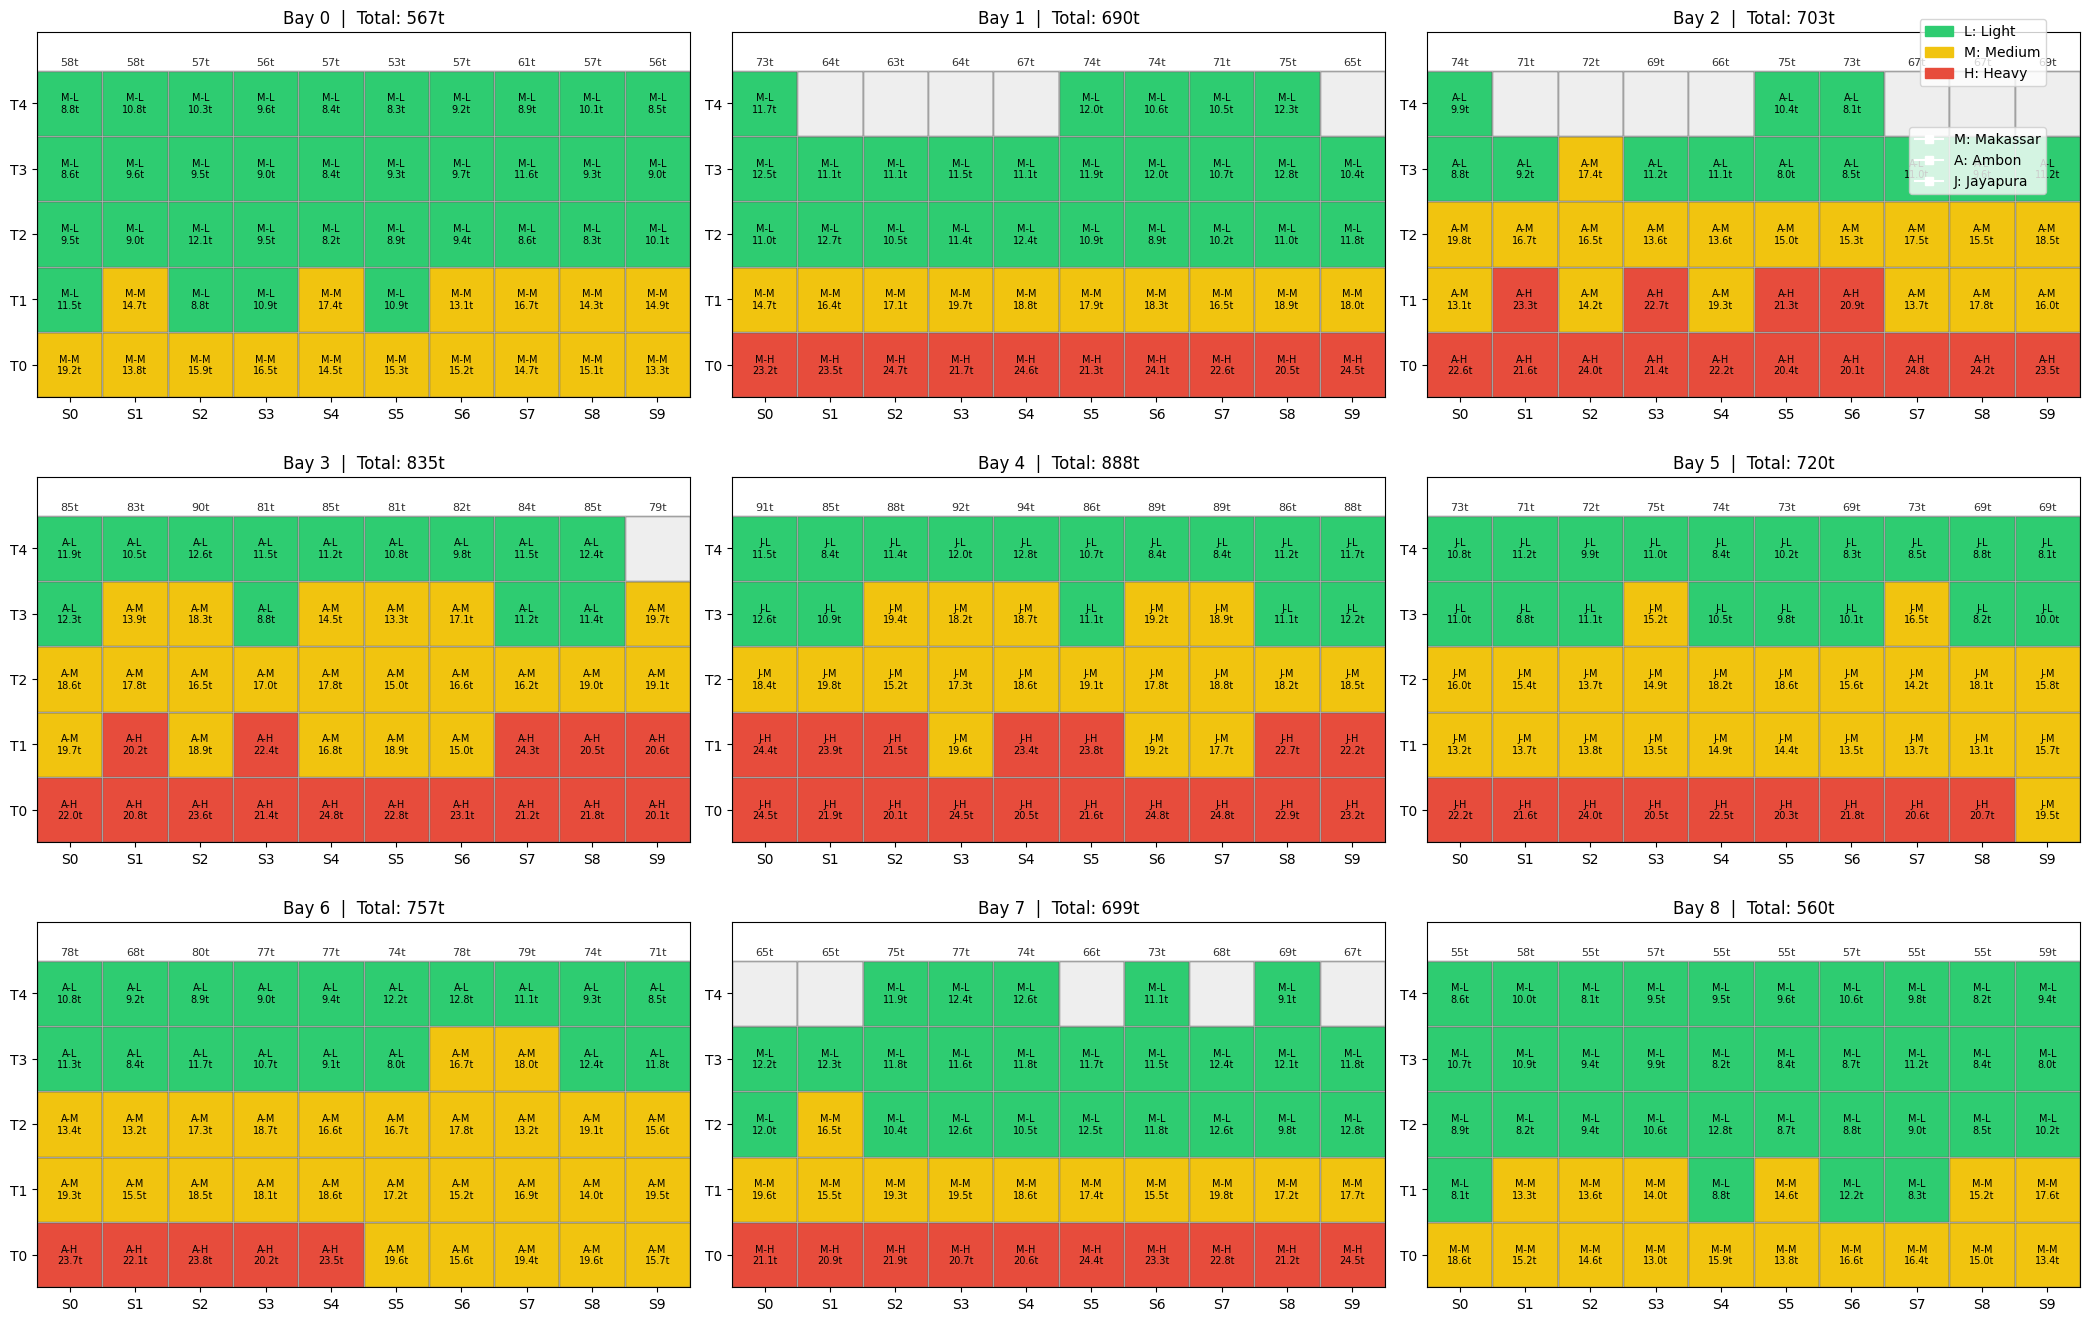

Total berat: 6419.6 t
Kiri–Kanan (LR):
  Left: 3224.0 t | Right: 3195.6 t | Selisih: 28.4 t (0.44%)
Depan–Belakang (FA):
  Front: 3239.1 t | Aft: 3180.5 t | Selisih: 58.6 t (0.91%)
Atas–Bawah (Vertical):
  Bottom: 3374.9 t | Top: 3044.7 t | Selisih: 330.3 t (5.14%)
Kuadran (Front/Aft x Left/Right):
  FL: 1616.2 t | FR: 1622.9 t | AL: 1607.8 t | AR: 1572.7 t | Std: 19.3 t
Pusat Massa (indeks kontinu):
  Bay: 4.00 dari [0..8], Stack: 4.49 dari [0..9], Tier: 1.58 dari [0..4]
=== Perhitungan GM (sederhana) ===
Cargo: 6419.6 t | LCG: -0.00 | TCG: -0.01 | KG: 5.40 m
Lightship: 3000.0 t | KG: 6.50 m
KB: 3.00 m | BMt: 4.00 m | BMl: 50.00 m
Displacement total: 9419.6 t | KG_total: 5.75 m
GMt (transversal): 1.25 m
GMl (longitudinal): 47.25 m
Status transversal: AMAN


In [344]:
# Gunakan alokasi otomatis bay dan jalankan ulang perencanaan + evaluasi
AUTO_PORT_TO_BAYS = auto_allocate_port_to_bays(PORTS, ALLOCATION_PER_PORT, BAYS, STACKS_PER_BAY, TIERS_PER_STACK)
print("PORT_TO_BAYS (auto, outside-in):", AUTO_PORT_TO_BAYS)

containers = generate_containers(TOTAL_CONTAINERS, ALLOCATION_PER_PORT, WEIGHT_MIX)
assignment = plan_stowage(containers, BAYS, STACKS_PER_BAY, TIERS_PER_STACK, PORTS, AUTO_PORT_TO_BAYS, fa_lambda=10.0)
# Rebalancing FA sampai selisih <=5% atau maksimal 100 perpindahan
assignment = rebalance_front_aft(assignment, BAYS, STACKS_PER_BAY, TIERS_PER_STACK, PORTS, AUTO_PORT_TO_BAYS, target_ratio=0.02, max_moves=1000)

visualize_all_bays_detailed(assignment, BAYS, STACKS_PER_BAY, TIERS_PER_STACK)
metrics = evaluate_balance(assignment, BAYS, STACKS_PER_BAY, TIERS_PER_STACK)
print_balance_report(metrics, BAYS, STACKS_PER_BAY, TIERS_PER_STACK)
print_GM_report(assignment, BAYS, STACKS_PER_BAY, TIERS_PER_STACK)

